In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import spsolve, gmres
from scipy.stats import norm
from scipy import sparse
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
plt.style.use('seaborn')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-16-181950352850>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 0. BSM equation


The Black-Scholes-Merton Partial Differential Equation (PDE) for option pricing is given by:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0
$$

where:
- $V$ is the price of the option as a function of stock price $S$ and time $t$.
- $\sigma$ is the volatility of the stock's returns.
- $r$ is the risk-free interest rate.
- $\frac{\partial V}{\partial t}$ is the partial derivative of the option price with respect to time.
- $\frac{\partial^2 V}{\partial S^2}$ is the second partial derivative of the option price with respect to the stock price.
- $\frac{\partial V}{\partial S}$ is the partial derivative of the option price with respect to the stock price.

**Boundary Conditions (BCs):**

For a call option:
1. At expiry ($t = T$), the option value is $V(S,T) = \max(S - K, 0)$, where $K$ is the strike price.
2. As $S \to 0$, $V \to 0$.
3. As $S \to \infty$, $V$ behaves like $S$, i.e., $V(S,t) \sim S - K e^{-r(T-t)}$.

For a put option:
1. At expiry ($t = T$), the option value is $V(S,T) = \max(K - S, 0)$.
2. As $S \to 0$, $V$ behaves like $K e^{-r(T-t)}$.
3. As $S \to \infty$, $V \to 0$.

These conditions ensure that the solution to the PDE conforms to the physical and financial realities of option pricing at expiry and for extreme values of the underlying asset price.




## 1. Finite Difference - Crank Nicolson for Linear BSM



In [3]:
def crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r, k, type):
  """
  Uses the Crank-Nicolson method to solve the BSM equation.
  Inputs:
    dS: discretization step of the stock price
    S_max: maximum stock price
    dt: discretization step of the time
    tf: final time
    sigma: volitility of the stock price
    k: strike price
    type: 'PUT' or 'CALL' to specify type of option (string)

  Outputs:
    V: options price
    S: stock price domain (for plotting)
    T: time domain (for plotting)

  """
  assert type == 'PUT' or type == 'CALL', "'type' must be 'CALL' or 'PUT'"

  N = int((S_max / dS) - 1) #number of interior points
  S = np.linspace(0, S_max, N+2)
  T = np.arange(0, tf+dt, dt)

  N_r = np.arange(1, N+1).reshape(-1, 1) #ensure column-wise broadcasting

  I = np.eye(N)

  #define discretization matrices
  A_ss = np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1)
  A_s = np.diag(0.5*np.ones(N-1), k=1) + np.diag(-0.5*np.ones(N-1), k=-1)

  #set up matrices for Crank-Nicolson method
  RHS = I + 0.5*dt * (0.5 * sigma**2 * N_r**2 * A_ss + r * N_r * A_s - r * I)
  LHS = I - 0.5*dt * (0.5 * sigma**2 * N_r**2 * A_ss + r * N_r* A_s - r * I)
  RHS = csr_matrix(RHS)
  LHS = csr_matrix(LHS)

  #set up initial and boundary conditions for call options
  V = np.zeros((N+2, len(T)))

  if type == 'CALL':
    V[1:-1, -1] = np.maximum(dS * N_r.reshape(-1,) - k, 0)
    V[0, :] = 0
    V[-1, :] = S_max - k*np.exp(-r*(tf-T))

  if type == 'PUT':
    V[1:-1, -1] = np.maximum(K - dS * N_r.reshape(-1,), 0)
    V[0, :] = k*np.exp(-r*(tf-T))
    V[-1, :] = 0

  for i in range(len(T)-1, 0, -1):

    upper_boundary = 0.25*dt*(sigma**2 * N**2 - r * N) * (V[-1, i] + V[-1, i-1])
    lower_boundary = 0.25*dt*(sigma**2 + r ) * (V[0, i] + V[0, i-1])

    B = RHS.dot(V[1:-1, i])

    B[-1] += upper_boundary
    B[0] += lower_boundary

    #V[1:-1, i-1], info = gmres(LHS, B)

    V[1:-1, i-1] = spsolve(LHS, B)
    info = 0

    if info != 0:
      print(f'Warning: gmres convergence error. Info: {info}')
  return V, S, T

In [4]:
S_max = 200
dS = 1/10
dt = 1/2000
tf = 1
sigma = 0.2
r = 0.05
K=100

C, S, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='CALL')

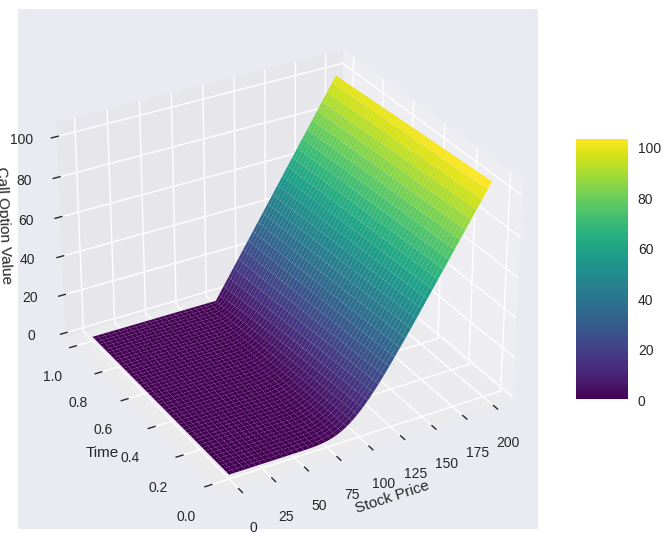

In [6]:
# Create meshgrid
T_, S_ = np.meshgrid(T, S)

# Creating the figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(S_, T_, C, cmap='viridis')

# Adding color bar which maps values to colors
fig.colorbar(surface, shrink=0.5, aspect=5)
# Labels for the axes
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time')
ax.set_zlabel('Call Option Value')
ax.view_init(azim=-120)

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CMOR 423: PDE Project/image5.png')


## 3. Results implementation and Error Analysis
Test Crank-Nicolson and supervised machine learning against exact solution.

In [8]:
S_max = 200
dS = 20
dt = 1/10
tf = 1
sigma = 0.2
r = 0.05
K=100

# test call and put options at different discretizations
C, S, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='CALL')
P, S, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='PUT')

dS = 10
C1, S1, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='CALL')
P1, S1, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='PUT')

dS = 5

C2, S2, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='CALL')
P2, S2, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  K, type='PUT')


In [9]:
# implement exact solutions
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the Black-Scholes price for a European call option.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price of the option
    T : float
        Time to maturity in years
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the stock price

    Returns:
    float
        Price of the call option
    """
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate the price of the call option
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

    return call_price


def black_scholes_put(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes-Merton price of a European put option.

    Parameters:
    - S0: Current price of the underlying asset
    - K: Strike price of the option
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the underlying asset's returns (annualized)

    Returns:
    - P: Price of the European put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    P = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return P

S_exact = np.linspace(0, 200, 500)
call_prices = [black_scholes_call(s, K, tf, r, sigma) for s in S_exact]
put_prices = [black_scholes_put(s, K, tf, r, sigma) for s in S_exact]

<ipython-input-9-a738bb5af25c>:23: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-9-a738bb5af25c>:46: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


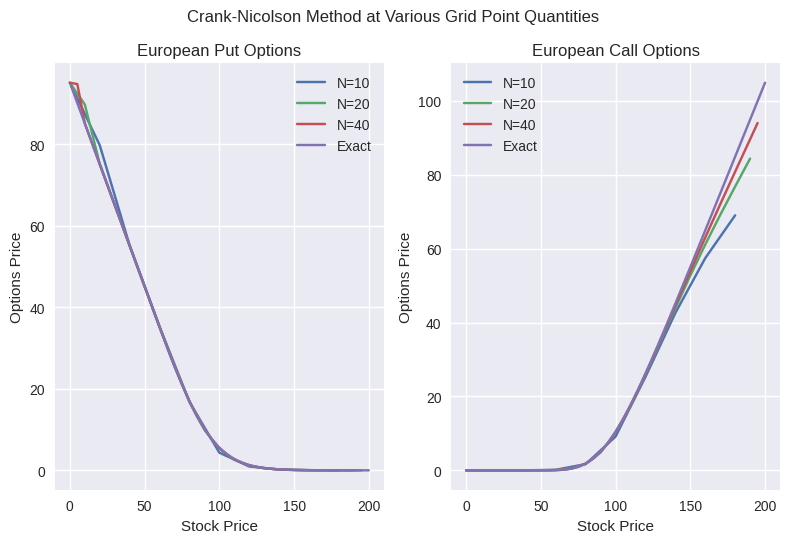

In [13]:
fig, axs  = plt.subplots(1, 2)
axs[0].plot(S[:-1], P[:-1,0], label='N=10')
axs[0].plot(S1[:-1], P1[:-1,0], label='N=20')
axs[0].plot(S2[:-1], P2[:-1,0], label='N=40')
axs[0].plot(S_exact[2:], put_prices[2:], label='Exact')
axs[0].legend()
axs[0].set_title('European Put Options')
axs[0].set_xlabel('Stock Price')
axs[0].set_ylabel('Options Price')

axs[1].plot(S[:-1], C[:-1,0], label='N=10')
axs[1].plot(S1[:-1], C1[:-1,0], label='N=20')
axs[1].plot(S2[:-1], C2[:-1,0], label='N=40')

axs[1].plot(S_exact, call_prices, label='Exact')
axs[1].legend()
axs[1].set_title('European Call Options')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Options Price')

fig.suptitle('Crank-Nicolson Method at Various Grid Point Quantities ')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CMOR 423: PDE Project/image6.png', dpi=500)

In [ ]:
def evaluate_convergence(step_sizes, method, exact_sol, show_progress=False):
    """
    Evaluates the numerical convergence of a time and 1D spatial PDE method.

    Inputs:
        step_sizes: a vector of step sizes to test sequentially
        method: a lambda function of the numerical method solution as a function either time or space steps
                e.g., method = lambda delta_t: numerical_method_example(delta_t, dx)
        exact_sol: a lambda function of the exact solution in the form exact_sol(x, t)

    Outputs:
        result: pandas table of step sizes, L2 norm error, and convergence rate
    """
    L2_error = np.zeros_like(step_sizes)
    N = np.zeros_like(L2_error)
    C = np.zeros_like(L2_error)
    N[0] = np.nan
    C[0] = np.nan

    for i, step_size in enumerate(step_sizes):
        U, X, T = method(step_size)

        u_exact = exact_sol(X, T[-1])

        """
        plt.plot(u_exact)
        plt.plot(U[:, 0])
        return 0
        """
        L2_error[i] = np.sqrt(1/np.size(U[:,0]) * np.sum((U[:,0] - u_exact[:])**2))

        if i > 0:
            N[i] = np.log(L2_error[i]/L2_error[i-1]) / np.log(step_sizes[i]/step_sizes[i-1])

        if show_progress:
            print('Iteration: ' + str(i+1) + ' / ' + str(len(step_sizes)))

    result = pd.DataFrame({
    r'step size': step_sizes,
    'L2 Error ': L2_error,
    'Rate' : N,
    })

    return result

In [ ]:
S_max = 200
dt = 1/1000
tf = 1
sigma = 0.2
r = 0.05
k=100


step_sizes = np.array([1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9, 1/10])

exact_sol = lambda S, T: black_scholes_call(S, k, tf, r, sigma)

method = lambda step_size: crank_nicolson_BSM(step_size, S_max, dt, tf, sigma, r, k, type='CALL')
print('Spatial (Stock Price) Step Size Convergence Analysis:')
evaluate_convergence(step_sizes, method, exact_sol, show_progress=True)

Spatial (Stock Price) Step Size Convergence Analysis:
Iteration: 1 / 10


<ipython-input-6-a738bb5af25c>:23: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10
Iteration: 10 / 10


,step size,L2 Error,Rate
0,1.000000,0.391757,NaN
1,0.500000,0.197635,0.987121
2,0.333333,0.132167,0.992326
3,0.250000,0.099291,0.994217
4,0.200000,0.079519,0.995135
5,0.166667,0.066318,0.995629
6,0.142857,0.056880,0.995900
7,0.125000,0.049797,0.996039
8,0.111111,0.044284,0.996093
9,0.100000,0.039872,0.996088


In [ ]:
def evaluate_convergence(step_sizes, method, exact_sol, show_progress=False):
    """
    Evaluates the numerical convergence of a time and 1D spatial PDE method.

    Inputs:
        step_sizes: a vector of step sizes to test sequentially
        method: a lambda function of the numerical method solution as a function either time or space steps
                e.g., method = lambda delta_t: numerical_method_example(delta_t, dx)
        exact_sol: a lambda function of the exact solution in the form exact_sol(x, t)

    Outputs:
        result: pandas table of step sizes, L2 norm error, and convergence rate
    """
    L2_error = np.zeros_like(step_sizes)
    N = np.zeros_like(L2_error)
    C = np.zeros_like(L2_error)
    N[0] = np.nan
    C[0] = np.nan

    for i, step_size in enumerate(step_sizes):
        U, X, T = method(step_size)

        u_exact = exact_sol(X, T[-1])

        """
        plt.plot(u_exact)
        plt.plot(U[:, 0])
        return 0
        """
        L2_error[i] = np.sqrt(1/np.size(U[:,0]) * np.sum((U[:,0] - u_exact[:])**2))

        if i > 0:
            N[i] = np.log(L2_error[i]/L2_error[i-1]) / np.log(step_sizes[i-1]/ step_sizes[i])

        if show_progress:
            print('Iteration: ' + str(i+1) + ' / ' + str(len(step_sizes)))

    result = pd.DataFrame({
    r'step size': step_sizes,
    'L2 Error ': L2_error,
    'Rate' : N,
    })

    return result

In [ ]:
S_max = 200
dt = 1/1000
dS = 1/10
tf = 1
sigma = 0.2
r = 0.05
k=100


S_max_varied = np.array([110.0, 120, 130, 140, 150])

exact_sol = lambda S, T: black_scholes_call(S, k, tf, r, sigma)

method = lambda S_max: crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r, k, type='CALL')
print('Spatial (Stock Price) Step Size Convergence Analysis:')

evaluate_convergence(S_max_varied, method, exact_sol, show_progress=True)

Spatial (Stock Price) Step Size Convergence Analysis:


<ipython-input-6-a738bb5af25c>:23: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Iteration: 1 / 5
Iteration: 2 / 5
Iteration: 3 / 5
Iteration: 4 / 5
Iteration: 5 / 5


,step size,L2 Error,Rate
0,110.0,0.705193,NaN
1,120.0,0.311500,9.390397
2,130.0,0.139515,10.034974
3,140.0,0.069794,9.346186
4,150.0,0.044218,6.615304


Comparison between Crank-Nicolson and Supervised Machine Learning

In [17]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CMOR 423: PDE Project/model_call')

63/63 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Classical BSM Equation via Supervised Machine Learning')

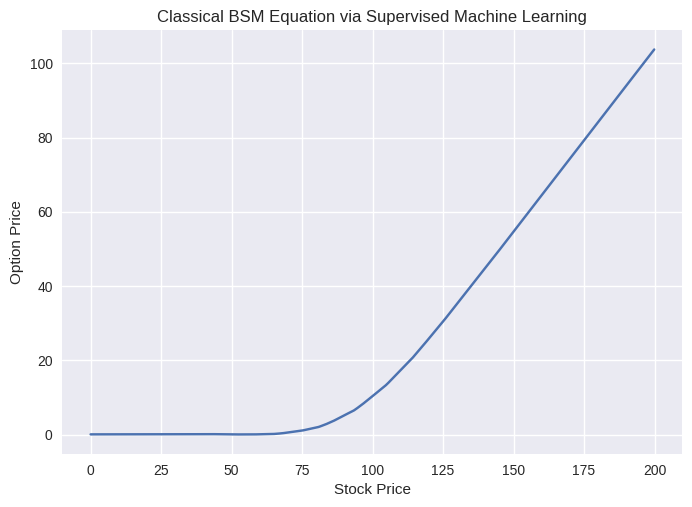

In [18]:

X_S = [[i/10, 100, 1, 0.05, 0.2] for i in range(0,2000)]
X_S = np.array(X_S)
pred_option_price = model.predict(X_S)
Stock_price = X_S[:, 0]

result = pd.DataFrame(np.column_stack((Stock_price, pred_option_price)),columns=['stock_price', 'option_price'])

plt.plot(Stock_price, pred_option_price)
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Classical BSM Equation via Supervised Machine Learning')


In [19]:
S_max = 200
dS = 1/10
dt = 1/2000
tf = 1
sigma = 0.2
r = 0.05
k=100

#compute CN, supervised learning, and exact solutions
C, S, T = crank_nicolson_BSM(dS, S_max, dt, tf, sigma, r,  k, type='CALL')
call_prices = black_scholes_call(S, k, tf, r, sigma)

X_S = np.column_stack([S, k*np.ones_like(S), tf*np.ones_like(S), r*np.ones_like(S), sigma*np.ones_like(S)])
pred_option_price = model.predict(X_S)

25/63 [==========>...................] - ETA: 0s

<ipython-input-9-a738bb5af25c>:23: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


63/63 [==============================] - 0s 2ms/step


In [20]:
err_CN_ML = np.sqrt(1/np.size(C[:, 0])**2 * np.sum((C[:, 0] - pred_option_price[:])**2))
err_CN_ex = np.sqrt(1/np.size(C[:, 0])**2 * np.sum((C[:, 0] - call_prices[:])**2))
err_ML_ex = np.sqrt(1/np.size(pred_option_price[:])**2 * np.sum((pred_option_price[:] - call_prices[:])**2))

print('Untruncated Errors:')
print(f'L2 Error Between Crank-Nicolson and Supervised ML: {err_CN_ML}')
print(f'L2 Error Between Exact Solution and Supervised ML: {err_ML_ex}')
print(f'L2 Error Between Crank-Nicolson and Exact Solution: {err_CN_ex}')

Untruncated Errors:
L2 Error Between Crank-Nicolson and Supervised ML: 47.374564994351886
L2 Error Between Exact Solution and Supervised ML: 47.39720346842463
L2 Error Between Crank-Nicolson and Exact Solution: 0.000891342842326996


In [21]:
# truncated solution tested for error to control differences near boundaries
err_CN_ML = np.sqrt(1/np.size(C[700:1200, 0])**2 * np.sum((C[700:1200, 0] - pred_option_price[700:1200])**2))
err_CN_ex = np.sqrt(1/np.size(C[700:1200, 0])**2 * np.sum((C[700:1200, 0] - call_prices[700:1200])**2))
err_ML_ex = np.sqrt(1/np.size(pred_option_price[700:1200])**2 * np.sum((pred_option_price[700:1200] - call_prices[700:1200])**2))

print('Truncated Errors:')
print(f'L2 Error Between Crank-Nicolson and Supervised ML: {err_CN_ML}')
print(f'L2 Error Between Exact Solution and Supervised ML: {err_ML_ex}')
print(f'L2 Error Between Crank-Nicolson and Exact Solution: {err_CN_ex}')

Truncated Errors:
L2 Error Between Crank-Nicolson and Supervised ML: 10.79634405002619
L2 Error Between Exact Solution and Supervised ML: 10.796635480813451
L2 Error Between Crank-Nicolson and Exact Solution: 2.4025365687244572e-05


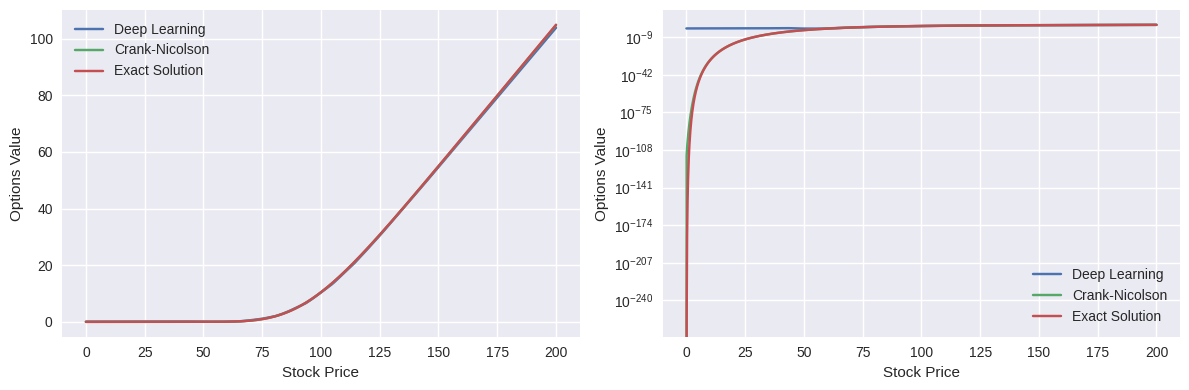

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(S, pred_option_price, label = 'Deep Learning')
axs[0].plot(S, C[:, 0], label = 'Crank-Nicolson')
axs[0].plot(S, call_prices, label = 'Exact Solution')
axs[0].set_ylabel('Options Value')
axs[0].set_xlabel('Stock Price')
axs[0].legend()


axs[1].plot(S, pred_option_price, label = 'Deep Learning')
axs[1].plot(S, C[:, 0], label = 'Crank-Nicolson')
axs[1].plot(S, call_prices, label = 'Exact Solution')
axs[1].set_yscale('log')
axs[1].set_ylabel('Options Value')
axs[1].set_xlabel('Stock Price')
axs[1].legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/CMOR 423: PDE Project/image7.png', dpi=500)

## 3. Crank-Nicolson with Newton Raphson to Solve Nonlinear BSM Model

In [ ]:
def nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, type, A, theta = 0.5, max_iter = 1000, eps=1e-8):
  """
  Uses the Crank-Nicolson method and change of varaibles to solve the nonlinear BSM equation.
  Inputs:
    dS: discretization step of the stock price
    S_max: maximum stock price
    dt: discretization step of the time
    tf: final time
    sigma_0: underlying volitility of the stock price
    k: strike price
    type: 'PUT' or 'CALL' to specify type of option (string)

  Outputs:
    V: options price
    S: stock price domain (for plotting)
    T: time domain (for plotting)

  """
  assert type == 'PUT' or type == 'CALL', "'type' must be 'CALL' or 'PUT'"

  # set up variables
  S_min = 1e-3
  N = int((S_max / dS) + 1) #number of grid points (including boundary)
  S = np.linspace(S_min, S_max, N)
  T = np.arange(0, tf+dt, dt)

  # transform variables
  tau = sigma_0**2 / 2 * (tf - T)
  x = np.linspace(np.log(S_min / k), np.log(S_max / k), N)

  S = k * np.exp(x)
  dtau = sigma_0**2 / 2 * dt

  dx = x[2]-x[1]
  dx = (np.log(S_max / k) - np.log(S_min / k)) / N
  U = np.zeros((N, len(tau)))

  if type == 'CALL':
    U[:, -1] = np.maximum(1-np.exp(-x), 0)
    beta = 1 - np.exp(-2*r / sigma_0**2 * tau - x[-1])
    alpha = np.zeros_like(beta)


  if type == 'PUT':
    U[:, -1] = np.maximum(np.exp(-x)-1, 0)

    alpha = np.exp(-2*r / sigma_0**2 * tau - x[0])
    beta = np.zeros_like(alpha)


  #define discretization matrices
  delta_xx = ( np.diag(-2*np.ones(N)) + np.diag(np.ones(N-1), k=1) + np.diag(np.ones(N-1), k=-1) ) / dx**2
  delta_x = (np.diag(0.5*np.ones(N-1), k=1) + np.diag(-0.5*np.ones(N-1), k=-1) ) / dx
  I = np.eye(N)



  sigma = lambda tau, x, gamma: 1 + A * np.sign(gamma+1e-9)
  Dsigma = lambda tau, x, gamma: np.where(gamma >= 0, 1 + A, 1 - A)
  theta_0 = theta

  for j in range(len(tau)-1, 0, -1):


    if j == (len(tau) - 1):
      theta = 0
    else:
      theta = theta_0

    u_old = U[:, j]
    u_new = u_old.copy()
    u_x_old = np.dot(u_old, delta_x)
    gamma_old = u_x_old + np.dot(u_old, delta_xx)

    for i in range(max_iter):

      u_x_new = np.dot(u_new, delta_x)
      gamma_new = u_x_new + np.dot(u_new, delta_xx)

      F = (-u_new + u_old) + dtau * theta * (sigma(tau,x,gamma_old) * gamma_old + 2 * r / sigma_0**2 * u_x_old) + dtau * (1-theta) *  (sigma(tau, x, gamma_new) * gamma_new + 2 * r / sigma_0**2 * u_x_new)
      F[0] = u_new[0]   - alpha[j-1]
      F[-1] = u_new[-1] - beta[j-1]

      DF = -I + dtau * (1-theta) * (Dsigma(tau, x, gamma_new).reshape(-1, 1) * (delta_x + delta_xx) + 2*r / sigma_0**2 * delta_x)
      DF[[0, -1], :] = 0
      DF[[0, -1], [0, -1]] = 1

      DF = csr_matrix(DF)
      dU = spsolve(DF, -F)

      if np.linalg.norm(dU) <= eps:
        #print('successful iteration ' + str(j))
        break

      u_new += dU

    # update U with new value
    U[:, j-1] = u_new

  V = np.zeros_like(U)
  V = U / np.exp(-x.reshape(-1, 1)) * k

  return V, S, T



"""
  Other boundary conditions and volatility models:

  if type == 'CALL':
    U[:, -1] = np.where(x >= 0, np.exp(-x) / k, 0)
    beta = np.exp(-2*r/sigma_0**2 * tau - x[-1]) / k
    alpha = np.zeros_like(beta)


  if type == 'CALL':
    U[:, -1] = np.where(x <= 0, np.maximum(1- 90/k * np.exp(-x), 0), np.maximum(110/k *np.exp(-x) - 1, 0))
    beta = np.zeros_like(alpha)
    alpha = np.zeros_like(beta)

  sigma_max = 0.25**2
  sigma_min = 0.15**2
  sigma = lambda tau, x, gamma: np.where(gamma <= 0, sigma_max, sigma_min)
  Dsigma = lambda tau, x, gamma: np.where(gamma <= 0, sigma_max, sigma_min)



"""


"\n  Other boundary conditions and volatility models:\n\n  if type == 'CALL':\n    U[:, -1] = np.where(x >= 0, np.exp(-x) / k, 0)\n    beta = np.exp(-2*r/sigma_0**2 * tau - x[-1]) / k\n    alpha = np.zeros_like(beta)\n\n\n  if type == 'CALL':\n    U[:, -1] = np.where(x <= 0, np.maximum(1- 90/k * np.exp(-x), 0), np.maximum(110/k *np.exp(-x) - 1, 0))\n    beta = np.zeros_like(alpha)\n    alpha = np.zeros_like(beta)\n\n  sigma_max = 0.25**2\n  sigma_min = 0.15**2\n  sigma = lambda tau, x, gamma: np.where(gamma <= 0, sigma_max, sigma_min)\n  Dsigma = lambda tau, x, gamma: np.where(gamma <= 0, sigma_max, sigma_min)\n\n  \n\n"

In [ ]:
S_max = 2000
dS = 5
dt = 1/250
tf = 1
sigma_0 = 0.2
r = 0.05
k=100

V_0, S_0, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.0,  theta = 0.5)
V_50, S_50, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.5,  theta = 0.5)
V_80, S_80, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.80,  theta = 0.5)
V_90, S_90, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.90,  theta = 0.5)
V_99, S_99, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.99,  theta = 0.5)

Text(0.5, 1.0, 'Leland Model for Options Pricing')

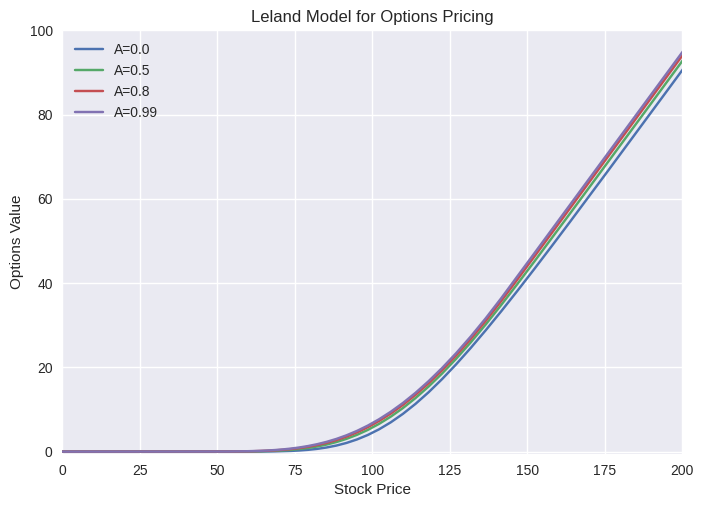

In [ ]:
plt.plot(S_0, V_0[:, 0], label='A=0.0')
plt.plot(S_50, V_50[:, 0], label = 'A=0.5')
plt.plot(S_80, V_80[:, 0], label = 'A=0.8')
#plt.plot(S_90, V_90[:, 0], label = 'A=0.95') # commented out for plot readability
plt.plot(S_99, V_99[:, 0], label = 'A=0.99')


plt.xlim([0, 200])
plt.ylim([-0.5, 100])
plt.xlabel('Stock Price')
plt.legend()
plt.ylabel('Options Value')
plt.title('Leland Model for Options Pricing')

In [ ]:
# check convergence by comparing against standard (many grid points and time steps)
S_max = 2000
dS = 5
dt = 1/250
tf = 1
sigma_0 = 0.2
r = 0.05
k=100
dS = 1
dt = 1/2000

V_exact, S_exact, T = nonlinear_BSM(dS, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.75,  theta = 0.5)


KeyboardInterrupt: 

In [ ]:

step_sizes = np.array([200.0,  100, 50, 40, 20, 10])

K=100
dt = 1/2000
error = np.zeros_like(step_sizes)
N = np.zeros_like(error)
N[0] = np.NaN
for i, step_size in enumerate(step_sizes):
  V_approx, S_approx, T_approx = nonlinear_BSM(step_size, S_max, dt, tf, sigma_0, r, k, 'CALL', 0.75,  theta = 0.5)
  error[i] = abs(V_exact[np.where(S_exact >=109.5)[0][0], 0] - V_approx[np.where(S_approx >= 109.5)[0][0], 0])
  print(S_approx[np.where(S_approx >=109.5)[0][0]])

  if i > 0:
    N[i] = np.log(error[i]/error[i-1]) / np.log(step_sizes[i]/step_sizes[i-1])

print(N)
result = pd.DataFrame({
  r'S step size': step_sizes,
  'Error ': error,
  'Rate' : N,
  })
result

109.85605433061181
109.85605433061181
109.85605433061181
109.85605433061181
109.85605433061181
109.85605433061181
[       nan 0.48963861 1.94590179 5.00660991 1.28292308 2.76353233]


,S step size,Error,Rate
0,200.0,2.511731,NaN
1,100.0,1.788863,0.489639
2,50.0,0.464304,1.945902
3,40.0,0.151919,5.006610
4,20.0,0.062433,1.282923
5,10.0,0.009194,2.763532
